In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(10),
  transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define transformations for the dataset
test_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root="datasets/cifar10", train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root="datasets/cifar10", train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)


Using device: cuda


100%|██████████| 170M/170M [00:02<00:00, 67.3MB/s] 


Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10
Files already downloaded and verified


In [24]:

# Define the CNN model
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # Added padding
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # New layer
    self.pool = nn.MaxPool2d(2)
    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(64)
    self.bn3 = nn.BatchNorm2d(128)  # New batch norm
    self.dropout1 = nn.Dropout2d(0.2)  # Reduced dropout
    self.dropout2 = nn.Dropout2d(0.3)

    # Calculate size dynamically
    dummy_input = torch.zeros(1, 3, 32, 32)
    conv_output_size = self._get_conv_output_size(dummy_input)
    
    self.fc1 = nn.Linear(conv_output_size, 256)  # Wider
    self.fc2 = nn.Linear(256, 10)

  def _get_conv_output_size(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.pool(F.relu(self.bn3(self.conv3(x))))
    x = self.dropout1(x)
    return torch.flatten(x, 1).shape[1]

  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.pool(F.relu(self.bn3(self.conv3(x))))
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.dropout2(x)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

# Initialize model, optimizer, and scaler
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
loss_fn = nn.CrossEntropyLoss()

In [25]:
# Training and testing functions
def train(model: CNN, optimizer: optim.Optimizer, loss_fn: nn.CrossEntropyLoss):
  model.train()
  total_loss = 0
  correct = 0
  for data, target in train_loader:
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    output: torch.Tensor = model(data)
    loss: torch.Tensor = loss_fn(output, target)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()

  accuracy = correct / len(train_loader.dataset)
  return total_loss / len(train_loader), accuracy

def test(model: CNN, loss_fn: nn.CrossEntropyLoss):
  model.eval()
  total_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output: torch.Tensor = model(data)
      loss: torch.Tensor = loss_fn(output, target)

      total_loss += loss.item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  accuracy = correct / len(test_loader.dataset)
  return total_loss / len(test_loader), accuracy


In [26]:
# Training loop
epochs = 50
for epoch in range(1, epochs + 1):
  train_loss, train_acc = train(model, optimizer, loss_fn)
  test_loss, test_acc = test(model, loss_fn)
  print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


/home/a2alhama/src/alignment/.venv/lib/python3.10/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1: Train Loss: 1.5418, Train Acc: 0.4366, Test Loss: 1.1630, Test Acc: 0.5853
Epoch 2: Train Loss: 1.2217, Train Acc: 0.5655, Test Loss: 0.9577, Test Acc: 0.6559
Epoch 3: Train Loss: 1.0986, Train Acc: 0.6100, Test Loss: 0.8736, Test Acc: 0.6963
Epoch 4: Train Loss: 1.0335, Train Acc: 0.6352, Test Loss: 0.8408, Test Acc: 0.7047
Epoch 5: Train Loss: 0.9821, Train Acc: 0.6521, Test Loss: 0.7790, Test Acc: 0.7291
Epoch 6: Train Loss: 0.9414, Train Acc: 0.6688, Test Loss: 0.7330, Test Acc: 0.7446
Epoch 7: Train Loss: 0.9101, Train Acc: 0.6829, Test Loss: 0.7273, Test Acc: 0.7451
Epoch 8: Train Loss: 0.8793, Train Acc: 0.6929, Test Loss: 0.7373, Test Acc: 0.7458
Epoch 9: Train Loss: 0.8583, Train Acc: 0.6982, Test Loss: 0.7130, Test Acc: 0.7469
Epoch 10: Train Loss: 0.8342, Train Acc: 0.7108, Test Loss: 0.6637, Test Acc: 0.7666
Epoch 11: Train Loss: 0.8208, Train Acc: 0.7148, Test Loss: 0.6542, Test Acc: 0.7709
Epoch 12: Train Loss: 0.7995, Train Acc: 0.7189, Test Loss: 0.6431, Test A

tensor([0], device='cuda:0')


/home/a2alhama/src/alignment/.venv/lib/python3.10/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/tmp/ipykernel_1992786/3270614746.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(classes, rotation=45)


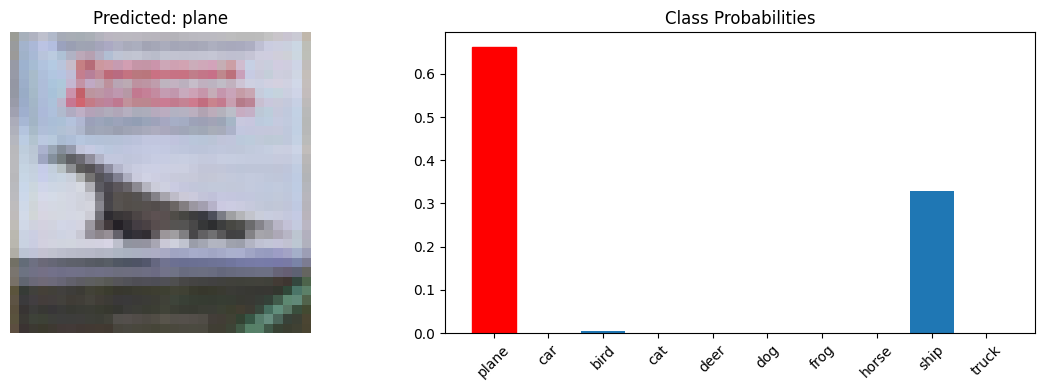

Tensor shape: torch.Size([3, 32, 32])
Value range: [-0.74, 0.84]
Label: 0. plane


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
            'dog', 'frog', 'horse', 'ship', 'truck')

# Method 1: Display a single image from the dataset directly
def show_image(dataset, index):
  # Get image and label
  image, label = dataset[index]

  show_tensor(image, label)
    
def show_tensor(image: torch.Tensor, label=None):
  image = image.cpu()
  # Convert tensor to numpy and transpose from (C,H,W) to (H,W,C)
  image = image.numpy().transpose(1, 2, 0)
  
  # Denormalize the image
  image = image * 0.5 + 0.5  # reverse the normalization you applied
  
  # CIFAR-10 classes
  classes = ('plane', 'car', 'bird', 'cat', 'deer', 
            'dog', 'frog', 'horse', 'ship', 'truck')
  
  plt.imshow(image)
  plt.title(f'Class: {classes[label] if label else "None Provided"}')
  plt.axis('off')
  plt.show()


# Method 3: If you want to see the raw pixel values
def show_image_details(dataset, index):
  image, label = dataset[index]
  print(f"Tensor shape: {image.shape}")
  print(f"Value range: [{image.min():.2f}, {image.max():.2f}]")
  print(f"Label: {label}. {classes[label]}")
  
def show_augmented_images(dataset, index, num_augmentations=5):
  # Get original image
  image, label = dataset[index]
  
  # Create a figure with num_augmentations+1 subplots (including original)
  fig, axes = plt.subplots(1, num_augmentations+1, figsize=(15, 3))
  
  # Show original
  axes[0].imshow(image.numpy().transpose(1, 2, 0) * 0.5 + 0.5)
  axes[0].set_title('Original')
  axes[0].axis('off')
  
  # Show augmented versions
  for i in range(num_augmentations):
    # Get the same image again (it will be newly augmented)
    aug_image, _ = dataset[index]
    axes[i+1].imshow(aug_image.numpy().transpose(1, 2, 0) * 0.5 + 0.5)
    axes[i+1].set_title(f'Augmented {i+1}')
    axes[i+1].axis('off')
  
  plt.tight_layout()
  plt.show()

def predict_with_plot(input: torch.Tensor):
  with torch.no_grad():
    input = input.to(device)
    output: torch.Tensor = model(input)
    probs = torch.exp(output)
    pred = output.argmax(dim=1)
    print(pred)
    pred_class = classes[pred.item()]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Show image in first subplot
    img = input[0].cpu().numpy().transpose(1, 2, 0)
    img = img * 0.5 + 0.5
    ax1.imshow(img)
    ax1.set_title(f'Predicted: {pred_class}')
    ax1.axis('off')
    
    # Show probabilities in second subplot
    probs_np = probs[0].cpu().numpy()
    bars = ax2.bar(classes, probs_np)
    ax2.set_title('Class Probabilities')
    ax2.set_xticklabels(classes, rotation=45)
    
    # Color the predicted class bar differently
    bars[pred.item()].set_color('red')
    
    plt.tight_layout()
    plt.show()


# Test it
image, label = test_dataset[3]
image = image.unsqueeze(0)
predict_with_plot(image)
show_image_details(test_dataset, 3)